Generate material maps using an existing model checkpoint.

In [51]:
import geopandas as gpd
import lightning.pytorch
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
import rasterio.plot
import torch.utils.data
import torchgeo.datasets
import torchgeo.samplers
import tqdm

import classification.datamodules
import classification.datasets
import classification.task

### Setup

In [52]:
# Enable TF32 support.
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.allow_tf32 = True

# Fix the RNGs.
lightning.pytorch.seed_everything(42, workers=True)

Seed set to 42


42

### Testing

In [53]:
# Instantiate the model in inference mode.
model = classification.task.TrainingTask.load_from_checkpoint("logs/RoofSense/best-v4.ckpt")
# NOTE: This command disables all batch normalization and dropout layers.
model.eval()

# Instantiate the datamodule.
datamodule = classification.datamodules.TrainingDataModule(root="../annotation/data",
                                                           batch_size=64,
                                                           patch_size=64,
                                                           num_workers=8)

# Instantiate the trainer.
trainer = lightning.Trainer(benchmark=True)

weights
['weights', 'ignore']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
# Test the model.
# FIXME: Do not log the test results..
trainer.test(model, datamodule=datamodule)

C:\Documents\RoofSense\classification\datasets.py:198: UserWarning: The spatial index of the dataset is being populated. This operation may require a considerable amount of time to complete.
  warnings.warn(msg, UserWarning)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.10130242258310318    │
│    test_macroAccuracy     │    0.35282567143440247    │
│     test_macroF1Score     │    0.3183049261569977     │
│       test_macroIoU       │    0.28116655349731445    │
│    test_macroPrecision    │    0.29790717363357544    │
│     test_macroRecall      │    0.35282567143440247    │
│    test_microAccuracy     │    0.9709164500236511     │
│     test_microF1Score     │    0.9709164500236511     │
│       test_microIoU       │    0.9434767365455627     │
│    test_microPrecision    │    0.9709164500236511     │
│     test_microRecall      │    0.9709164500236511     │
│   test_weightedAccuracy   │    0.9709164500236511     │
│   test_weightedF1Score    │    0.9819043874740601     │
│     test_weightedIoU      │    0.9661405086517334     │
│  test_weightedPrecision   │    0.9938250780105591     │
│    test_weightedRecall    │    0.9709164500236511     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10130242258310318,
  'test_macroAccuracy': 0.35282567143440247,
  'test_macroF1Score': 0.3183049261569977,
  'test_macroIoU': 0.28116655349731445,
  'test_macroPrecision': 0.29790717363357544,
  'test_macroRecall': 0.35282567143440247,
  'test_microAccuracy': 0.9709164500236511,
  'test_microF1Score': 0.9709164500236511,
  'test_microIoU': 0.9434767365455627,
  'test_microPrecision': 0.9709164500236511,
  'test_microRecall': 0.9709164500236511,
  'test_weightedAccuracy': 0.9709164500236511,
  'test_weightedF1Score': 0.9819043874740601,
  'test_weightedIoU': 0.9661405086517334,
  'test_weightedPrecision': 0.9938250780105591,
  'test_weightedRecall': 0.9709164500236511}]

### Inference

In [55]:
# Specify the chip size the stack should be split into.
# TODO: Find out why different sizes result in different maps.
PATCH_SIZE = 64

# Specify the batch size.
BATCH_SIZE = 64

# Instantiate the dataset.
# NOTE: The dataset must contain only the stack.
stack = classification.datasets.TrainingDataset("../annotation/data/")
stack.populate_index()

# Instantiate the sampler.
stack_sampler = torchgeo.samplers.GridGeoSampler(stack, size=PATCH_SIZE, stride=PATCH_SIZE // 2)

# Instantiate the loader.
stack_loader = torch.utils.data.DataLoader(stack,
                                           sampler=stack_sampler,
                                           collate_fn=torchgeo.datasets.stack_samples,
                                           batch_size=BATCH_SIZE,
                                           num_workers=8)

In [56]:
# Compute the stack transform.
stack_bbox = stack.bounds

# TODO: Compute the stack dimensions automatically.
stack_width = 1024
stack_height = 512

stack_transform = rasterio.transform.from_bounds(west=stack_bbox.minx,
                                                 south=stack_bbox.miny,
                                                 east=stack_bbox.maxx,
                                                 north=stack_bbox.maxy,
                                                 width=stack_width,
                                                 height=stack_height)

In [57]:
# Instantiate the map.
mmap = np.zeros([stack_height, stack_width], dtype=np.uint8)

x = 0
y = 0
for batch in tqdm.tqdm(stack_loader):
    chips = batch["image"].to(model.device)
    # Scale the images to the range expected by the model.
    # NOTE: All general-purpose augmentations must be applied at this stage.
    chips /= 255

    # Infer the segmentation mask corresponding to each image.
    # NOTE: This context manager disables all automatic differentiation functionality.
    #       See https://stackoverflow.com/questions/74191070/why-there-are-two-different-flags-to-disable-gradient-computation-in-pytorch/74197846#74197846 for more information.
    with torch.inference_mode():
        masks = model(chips).argmax(dim=1).cpu().numpy()

    # ----------
    # TODO
    # iterate through the batch and paste the predictions where they belong
    for i in range(BATCH_SIZE):
        bbox = batch["bbox"][i]

        # Create a polygon from the bbox
        geom = {
            "type": "Polygon",
            "coordinates": [
                [[bbox.minx, bbox.miny], [bbox.minx, bbox.maxy], [bbox.maxx, bbox.maxy], [bbox.maxx, bbox.miny],
                 [bbox.minx, bbox.miny]  # Close the loop
                 ]]}
        mask_locs = rasterio.features.geometry_mask([geom],
                                                    transform=stack_transform,
                                                    invert=True,
                                                    out_shape=(stack_height, stack_width))
        mmap[mask_locs] = masks[i].ravel()

 38%|███▊      | 3/8 [00:06<00:11,  2.33s/it]


ValueError: NumPy boolean array indexing assignment cannot assign 4096 input values to the 2048 output values where the mask is true

In [58]:
# Load and dissolve the corresponding roof surfaces.
surfs = gpd.read_file("../annotation/data/tmp/9-284-556.surfs.gpkg").dissolve()

# Remask the background.
bg_mask = rasterio.features.geometry_mask(surfs.geometry,
                                          out_shape=(stack_height, stack_width),
                                          transform=stack_transform)

mmap[bg_mask] = 0

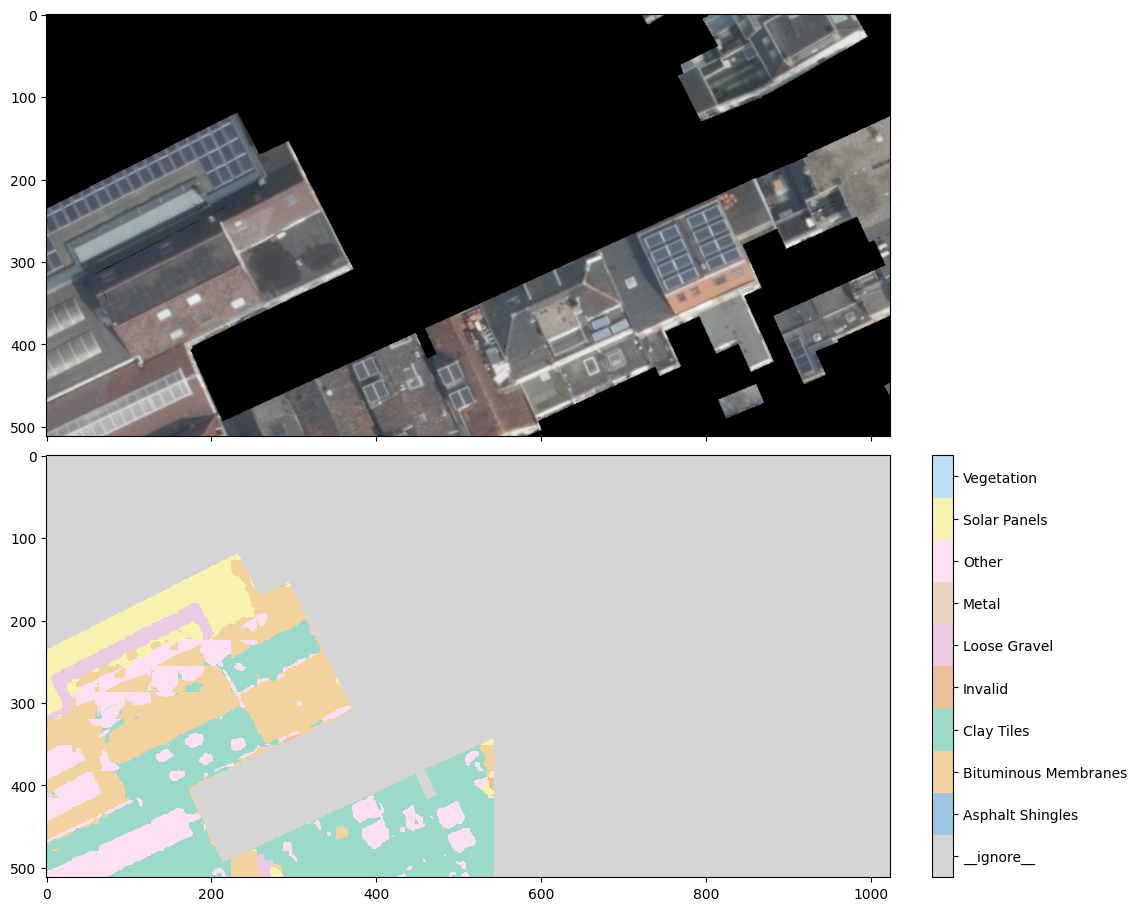

In [60]:
# Visualize the stack and map.
fig: plt.Figure
ax: plt.Axes
fig, axs = plt.subplots(2, 1, layout="compressed", sharex=True, sharey=True, figsize=(16, 9))

stack_plot = axs[0].imshow(rasterio.plot.reshape_as_image(stack[stack_bbox]["image"].numpy() / 255))
mmap_plot = axs[1].imshow(mmap, vmin=0, vmax=len(stack.classes), cmap=stack._lc_cmap, interpolation="None")

cbar = plt.colorbar(mmap_plot)
cbar.set_ticks(np.arange(len(stack.classes)) + 0.5, labels=stack.classes)